In [0]:
import numpy as np 
import pandas as pd 
from pathlib import Path
from fastai.text import *

In [0]:
path = Path("/content/drive/My Drive/midas_reddit_flair")

In [5]:
flair_df = pd.read_csv(path/'reddit_flair_data_midas.csv')
print(flair_df.shape)
print(flair_df['flair'].value_counts())
flair_df = flair_df.reindex(np.random.permutation(flair_df.index))
flair_df.head()

(122254, 5)
Policy/Economy        19974
Science/Technology    19971
Politics              19925
Business/Finance      19461
Sports                 8248
Coronavirus            7985
Demonetization         7308
Policy                 5792
Photography            4663
Entertainment          4609
Food                   4318
Name: flair, dtype: int64


,title,body,combined,flair,combined_clean
49810,Indian Game Development Studio Tour In Mumbai 🎮🏢,NaN,Epic Royal Challengers Bangalore Troll.,Science/Technology,epic royal challengers bangalore troll
18139,Mumkin hai,\nhttps://inc42.com/buzz/tiktok-addicted-india...,TikTok-Addicted Indians Spent Over 5.5 Bn Hour...,Policy/Economy,tiktokaddicted indians spent over bn hours on...
12048,FinMin unsatisfied with Infosys-designed GSTN-...,NaN,Vehicle insurance to cost 5% to 15% more from ...,Policy/Economy,vehicle insurance to cost to more from april
33533,"""Huge Victory"": Traders, Farmers' Groups Prais...",NaN,"Woman Complains of Fly in Biryani, Zomato Exec...",Politics,woman complains of fly in biryani zomato execu...
36980,Tough NYT editorial on Kashmir,\nhttps://www.altnews.in/godse-fans-common-fol...,What do these Nathuram Godse fans have in comm...,Politics,what do these nathuram godse fans have in comm...


#### Training a language model
First a language model is trained for the reddit data. The reason to do is to make the the encoder better.

In [3]:
data_lm = (TextList
           .from_csv(path, 'reddit_flair_data_midas.csv', cols='combined_clean')
           .split_by_rand_pct(0.2)
           .label_for_lm()
           .databunch(bs=64))

In [4]:
data_lm.show_batch()

idx,text
0,and east asia prof srikanth kondapalli discussion full qampa xxbos battle of xxunk and xxunk who wins arjun does nt have sri krishna both with their all xxunk no bhramastra xxunk xxunk for both fight to death xxbos survey on live streaming apps like xxunk live please help hello everyone i m an entrepreneur and i m looking to startup in few months again i plan to build an app
1,isro first satellites emergency india economic crisis xxunk mehta scam keep suggesting please post only those events which directly or indirectly affected india in a positive or negative way other suggestions are also welcome well revisit them some other time thanks xxbos rindia if money is no bar would you prefer to stay in india or outside seems like everybody here is very critical of the direction india is heading
2,india news times of india xxbos clearest view of supermoon from delhi because no pollution xxbos india agrees to release xxunk corona drug xxbos it union seeks action against firm for asking employees to take leave xxbos ca nt help worrying about the xenophobia and polarisation that is catching on in this country a little context here me and this friend of mine are from one of the very best
3,the skills to be doctor rather they are forced to do forgery will there be an end to this the people who are suffering from this can not voice their opinions and views and have to suffer in silence with some going through mental trauma and depression i will not be revealing my identity but i may reveal the identity of the institution if the post reaches people and could
4,people who commute using their own vehicles or use public transportation we will be saving the costs for that this month this part of our monthly budget is now available to us for donation we should donate as much as we can from the money we are saving by wfh i do understand it might not be possible for everyone and not everyone can donate the complete amount but many


#### Using pretrained AWD_LSTM language model

In [6]:
language_model = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)
language_model.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


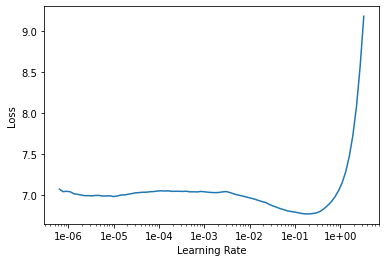

In [7]:
language_model.recorder.plot()

In [8]:
language_model.fit_one_cycle(2, 2*1e-2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,5.201123,5.122485,0.218555,02:17
1,4.999893,4.900257,0.225903,02:17


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


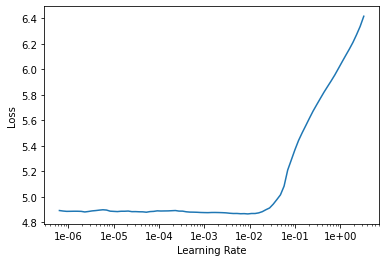

In [9]:
language_model.unfreeze()
language_model.lr_find()
language_model.recorder.plot()

In [11]:
language_model.fit_one_cycle(2, slice(1e-4, 1e-2), moms=(0.85, 0.75))

epoch,train_loss,valid_loss,accuracy,time
0,4.607925,4.706515,0.250799,02:19
1,4.518894,4.624360,0.271226,02:19


In [0]:
language_model.save('fine_tuned_reddit_language_model')

In [0]:
language_model.save_encoder('language_encoder')

In [15]:
data_clas = TextClasDataBunch.from_csv(path,
                                      'reddit_flair_data_midas.csv',
                                      valid_pct=0.2,
                                      vocab=data_lm.train_ds.vocab,
                                      text_cols = 'combined_clean', label_cols = 'flair',
                                      bs=64)

In [16]:
data_clas.show_batch()

text,target
xxbos the antipoor xxunk bill that xxunk quackery and reduces clinical skills of doctors if that were possible tldr people just glance through the headings and the bold font please do read those it is a very important matter between teen xxunk chandrayan nationwide floods article and economic crash most of you must not have noticed the national medical commission bill nmc that was xxunk into the parliament and passed,Business/Finance
xxbos tips and advice for engineers in tech field i want to start this by saying that i am still in my final year of engineering and by no means all of which is written here the only path to succeed in the field this is just a handful of resources and bits of advice which i wished i had received during my early years of engineering so i ve,Sports
xxbos quick recap and the latest on what happened with maharashtra government formation disclaimer the following is written in good humor and is not intended to offend the sentiments of any person group party or organization living or dead if you are someone who gets easily offended stop reading right away and go back to where you were before the click bait brought you here what happens next will blow,Photography
xxbos demonetization what would success look like who will be the long term beneficiary it it worked and do the supporters know that going through the opinions of those supporting or at least ambivalent about this giant exercise it appears that the thoughtful ones of that group expect the following long term benefits cheap and abundant credit availability in the economy if a good fraction of the cash deposited in,Science/Technology
xxbos india an expectation to predict the future of a society one should have a deep understanding with the grassroots and the elite simultaneously combined with deep xxunk even as complex a country as india which is the xxunk of sheer diversity a single man understood it united it for a cause and rallied it like never before in the human history his name is mohandas xxunk gandhi many less,Policy


In [17]:
classifier = text_classifier_learner(data_clas, AWD_LSTM)
classifier.load_encoder('language_encoder')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (97803 items)
x: TextList
xxbos late payment fees waived for delayed gst returns filing,xxbos lies in parliament,xxbos world cup points table update,xxbos xxunk seek clarity on aadhaar,xxbos mahendra singh dhoni steps down as odi and ti captain of the indian cricket team
y: CategoryList
Demonetization,Demonetization,Photography,Demonetization,Business/Finance
Path: /content/drive/My Drive/midas_reddit_flair;

Valid: LabelList (24451 items)
x: TextList
xxbos tourists forced to write sorry times after breaching india lockdown,xxbos xxunk indias bureaucracy and governance with artificial intelligence,xxbos xxunk app exposed for uploading users contacts to company servers without proper permissions,xxbos well he was wrong oc,xxbos no room for section in a democracy the shashi tharoor podcast on lgbt rights
y: CategoryList
Business/Finance,Science/Technology,Policy/Economy,Coronavirus,Policy
Path: /content/drive/My Drive/midas_reddit_flai

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


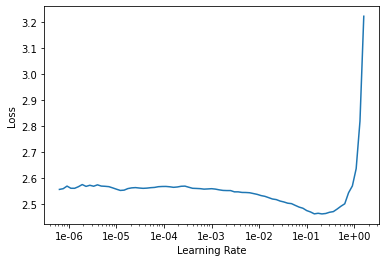

In [18]:
classifier.lr_find()
classifier.recorder.plot()

In [19]:
classifier.fit_one_cycle(2, 5*1e-2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.160527,2.110754,0.245225,02:17
1,1.503438,1.655176,0.567392,02:19


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


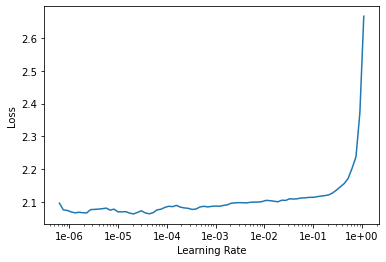

In [21]:
classifier.unfreeze()
classifier.lr_find()
classifier.recorder.plot()

In [23]:
classifier.fit_one_cycle(2, 5*1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.016519,1.222364,0.688495,02:30
1,0.774699,0.822639,0.780090,02:26


In [0]:
classifier.export('reddit_flair_classifier')
classifier = load_learner(path, 'reddit_flair_classifier')

In [0]:
classifier.predict("market finance")